# NGS variant calling workflow

## Case

Two exome sequencing samples of a T-Cell Acute Lymphoblastic Leukemia patient. 

One sample (`TLE66_T`) is of tumor, one healthy control sample  (`TLE66_N`)

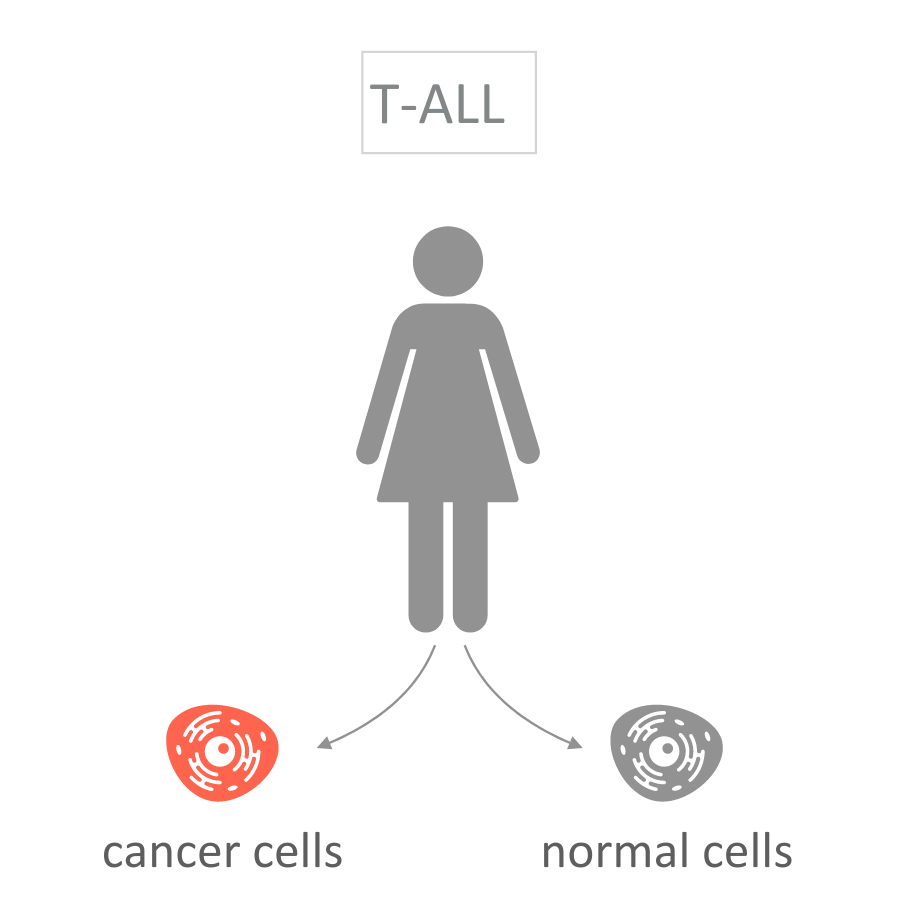

Goal: process the raw fastq, call & annotate SNPs.

We want to ultimately find interesting variants that may be causal to the T-ALL.

## Preparation

In [1]:
# make sure we add our conda environment to the path
# there are also a number of command line tools installed
export PATH=$VSC_DATA/miniconda3/bin:$PATH

In [2]:
# some tools I forgot to include in the environment.yml
# install them manually now:
#mamba install -q samtools bcftools

In [3]:
# create a work folder!
cd $VSC_SCRATCH
mkdir -p variant_calling_manual
cd variant_calling_manual
pwd
ls

/scratch/leuven/344/vsc34479/variant_calling_manual


In [4]:
# We will be using the genome sequence & index a few times - 
# So I'll use an environment variable
DB=/staging/leuven/stg_00079/teaching/hg19_9/chr9.fa

In [5]:
# Create a symlink to VSC_SCRATCH from $VSC_DATA -
# so that you can inspect your data using the jupyter file browser
ln -sf $VSC_SCRATCH $VSC_DATA/scratch 

In [6]:
# Copy the data to your location
cp -u /staging/leuven/stg_00079/teaching/raw/workflow1/*.fastq .
ls -l

total 170740
-rw-r----- 1 vsc34479 vsc34479 96642077 Mar 10 15:21 TLE66_N.fastq
-rw-r----- 1 vsc34479 vsc34479 86142568 Mar 10 15:21 TLE66_T.fastq


The `sha256` checksums of these files are supposed to be:

    5ad4bb2f5bd5f6e430b7ab2fff0a164255d4e608363104a75142b6c5a032ddf9  TLE66_N.fastq
    cd9d41d1c0b59a4819fa58007ef796c543b1a7346cb11cceb71ad02d9e2b2cfe  TLE66_T.fastq


## FASTQ Quality check

#### Low tech

**check:**

* No of reads (line count divided by four)
* Is the last record correct?
* Are the checksum correct?

#### High tech - run fastqc 

In [7]:
# you can get help using
fastqc --help


            FastQC - A high throughput sequence QC analysis tool

SYNOPSIS

	fastqc seqfile1 seqfile2 .. seqfileN

    fastqc [-o output dir] [--(no)extract] [-f fastq|bam|sam] 
           [-c contaminant file] seqfile1 .. seqfileN

DESCRIPTION

    FastQC reads a set of sequence files and produces from each one a quality
    control report consisting of a number of different modules, each one of 
    which will help to identify a different potential type of problem in your
    data.
    
    If no files to process are specified on the command line then the program
    will start as an interactive graphical application.  If files are provided
    on the command line then the program will run with no user interaction
    required.  In this mode it is suitable for inclusion into a standardised
    analysis pipeline.
    
    The options for the program as as follows:
    
    -h --help       Print this help file and exit
    
    -v --version    Print the version of the program and exit

In [8]:
# Run fastqc - could take a minute or two
mkdir -p fastqc_output
fastqc *.fastq -o fastqc_output

Started analysis of TLE66_N.fastq
Approx 5% complete for TLE66_N.fastq
Approx 10% complete for TLE66_N.fastq
Approx 15% complete for TLE66_N.fastq
Approx 20% complete for TLE66_N.fastq
Approx 25% complete for TLE66_N.fastq
Approx 30% complete for TLE66_N.fastq
Approx 35% complete for TLE66_N.fastq
Approx 40% complete for TLE66_N.fastq
Approx 45% complete for TLE66_N.fastq
Approx 50% complete for TLE66_N.fastq
Approx 55% complete for TLE66_N.fastq
Approx 60% complete for TLE66_N.fastq
Approx 65% complete for TLE66_N.fastq
Approx 70% complete for TLE66_N.fastq
Approx 75% complete for TLE66_N.fastq
Approx 80% complete for TLE66_N.fastq
Approx 85% complete for TLE66_N.fastq
Approx 90% complete for TLE66_N.fastq
Approx 95% complete for TLE66_N.fastq
Analysis complete for TLE66_N.fastq
Started analysis of TLE66_T.fastq
Approx 5% complete for TLE66_T.fastq
Approx 10% complete for TLE66_T.fastq
Approx 15% complete for TLE66_T.fastq
Approx 20% complete for TLE66_T.fastq
Approx 25% complete for 

Back in your jupyter browser you can see the html & zip outputs

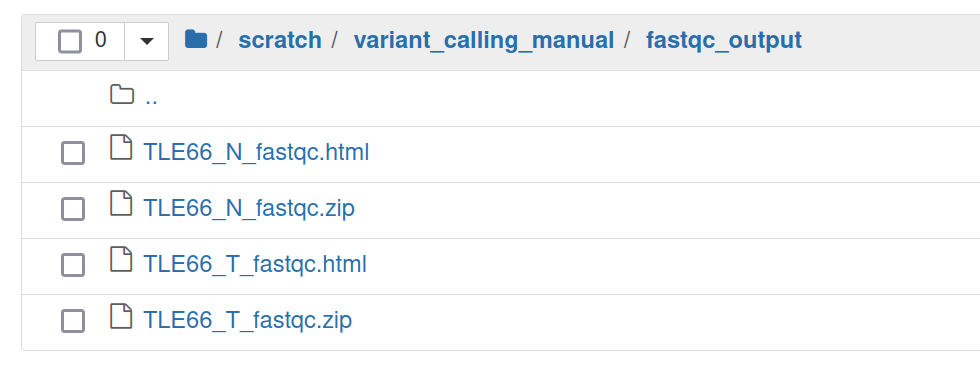

**Check:**

* The HTML output
* What is in the ZIP files - can you use that for later, automatic, QC?


## Align the reads

We will be using `bwa mem`. Get help by running without arguments

In [9]:
bwa mem


Usage: bwa mem [options] <idxbase> <in1.fq> [in2.fq]

Algorithm options:

       -t INT        number of threads [1]
       -k INT        minimum seed length [19]
       -w INT        band width for banded alignment [100]
       -d INT        off-diagonal X-dropoff [100]
       -r FLOAT      look for internal seeds inside a seed longer than {-k} * FLOAT [1.5]
       -y INT        seed occurrence for the 3rd round seeding [20]
       -c INT        skip seeds with more than INT occurrences [500]
       -D FLOAT      drop chains shorter than FLOAT fraction of the longest overlapping chain [0.50]
       -W INT        discard a chain if seeded bases shorter than INT [0]
       -m INT        perform at most INT rounds of mate rescues for each read [50]
       -S            skip mate rescue
       -P            skip pairing; mate rescue performed unless -S also in use

Scoring options:

       -A INT        score for a sequence match, which scales options -TdBOELU unless overridden [1]
     

: 1

In [10]:
# Environment variable with the genome database
HG19=/staging/leuven/stg_00079/teaching/hg19/Homo_sapiens_assembly19_sorted.fasta

In [11]:
bwa mem


Usage: bwa mem [options] <idxbase> <in1.fq> [in2.fq]

Algorithm options:

       -t INT        number of threads [1]
       -k INT        minimum seed length [19]
       -w INT        band width for banded alignment [100]
       -d INT        off-diagonal X-dropoff [100]
       -r FLOAT      look for internal seeds inside a seed longer than {-k} * FLOAT [1.5]
       -y INT        seed occurrence for the 3rd round seeding [20]
       -c INT        skip seeds with more than INT occurrences [500]
       -D FLOAT      drop chains shorter than FLOAT fraction of the longest overlapping chain [0.50]
       -W INT        discard a chain if seeded bases shorter than INT [0]
       -m INT        perform at most INT rounds of mate rescues for each read [50]
       -S            skip mate rescue
       -P            skip pairing; mate rescue performed unless -S also in use

Scoring options:

       -A INT        score for a sequence match, which scales options -TdBOELU unless overridden [1]
     

: 1

In [12]:
bwa mem ${DB} TLE66_N.fastq | samtools sort - > TLE66_N.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 133334 sequences (10000050 bp)...
[M::process] read 133334 sequences (10000050 bp)...
[M::mem_process_seqs] Processed 133334 reads in 3.045 CPU sec, 3.055 real sec
[M::process] read 133334 sequences (10000050 bp)...
[M::mem_process_seqs] Processed 133334 reads in 3.517 CPU sec, 3.601 real sec
[M::process] read 133334 sequences (10000050 bp)...
[M::mem_process_seqs] Processed 133334 reads in 3.542 CPU sec, 3.625 real sec
[M::process] read 7288 sequences (546600 bp)...
[M::mem_process_seqs] Processed 133334 reads in 4.483 CPU sec, 4.617 real sec
[M::mem_process_seqs] Processed 7288 reads in 0.293 CPU sec, 0.366 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem /staging/leuven/stg_00079/teaching/hg19_9/chr9.fa TLE66_N.fastq
[main] Real time: 17.438 sec; CPU: 15.248 sec


In [13]:
bwa mem ${DB} TLE66_T.fastq | samtools sort - > TLE66_T.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 133334 sequences (10000050 bp)...
[M::process] read 133334 sequences (10000050 bp)...
[M::mem_process_seqs] Processed 133334 reads in 3.022 CPU sec, 3.034 real sec
[M::process] read 133334 sequences (10000050 bp)...
[M::mem_process_seqs] Processed 133334 reads in 3.400 CPU sec, 3.482 real sec
[M::process] read 77886 sequences (5841450 bp)...
[M::mem_process_seqs] Processed 133334 reads in 3.563 CPU sec, 3.642 real sec
[M::mem_process_seqs] Processed 77886 reads in 2.824 CPU sec, 2.906 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem /staging/leuven/stg_00079/teaching/hg19_9/chr9.fa TLE66_T.fastq
[main] Real time: 13.354 sec; CPU: 13.055 sec


In [14]:
# create indici
samtools index TLE66_N.bam
samtools index TLE66_T.bam

In [15]:
pwd
ls -l

/scratch/leuven/344/vsc34479/variant_calling_manual
total 245056
drwxr-x--- 2 vsc34479 vsc34479     4096 Mar 10 15:23 fastqc_output
-rw-r----- 1 vsc34479 vsc34479 36386494 Mar 10 15:24 TLE66_N.bam
-rw-r----- 1 vsc34479 vsc34479    80248 Mar 10 15:25 TLE66_N.bam.bai
-rw-r----- 1 vsc34479 vsc34479 96642077 Mar 10 15:21 TLE66_N.fastq
-rw-r----- 1 vsc34479 vsc34479 32481281 Mar 10 15:24 TLE66_T.bam
-rw-r----- 1 vsc34479 vsc34479    79816 Mar 10 15:25 TLE66_T.bam.bai
-rw-r----- 1 vsc34479 vsc34479 86142568 Mar 10 15:21 TLE66_T.fastq


#### Quality control

**Check:**


* Is the header correct? (Use `samtools view -H`)
* Do the files look like BAM? (Use `samtools view ... | head)
* High tech: To which chromosomes to the reads map? (Use `samtools idxstats`)
* High tech: How many reads map properly? (Use `samtools flagstat`)
* Download the bam & bai files to disk & visualize in [IGV](https://igv.org/app/)

**Note:** be careful piping too much data to screen!

## SNP Calling

Using bcftools

In [16]:
#get help
bcftools mpileup


Usage: bcftools mpileup [options] in1.bam [in2.bam [...]]

Input options:
  -6, --illumina1.3+      Quality is in the Illumina-1.3+ encoding
  -A, --count-orphans     Do not discard anomalous read pairs
  -b, --bam-list FILE     List of input BAM filenames, one per line
  -B, --no-BAQ            Disable BAQ (per-Base Alignment Quality)
  -C, --adjust-MQ INT     Adjust mapping quality [0]
  -D, --full-BAQ          Apply BAQ everywhere, not just in problematic regions
  -d, --max-depth INT     Max raw per-file depth; avoids excessive memory usage [250]
  -E, --redo-BAQ          Recalculate BAQ on the fly, ignore existing BQs
  -f, --fasta-ref FILE    Faidx indexed reference sequence file
      --no-reference      Do not require fasta reference file
  -G, --read-groups FILE  Select or exclude read groups listed in the file
  -q, --min-MQ INT        Skip alignments with mapQ smaller than INT [0]
  -Q, --min-BQ INT        Skip bases with baseQ/BAQ smaller than INT [1]
      --max-BQ INT   

: 1

In [17]:
bcftools mpileup -Ou -f ${DB} TLE66_N.bam TLE66_T.bam \
    | bcftools call -mv -Ov -o raw_snps.vcf

Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 2 samples in 2 input files
[mpileup] maximum number of reads per input file set to -d 250


In [18]:
ls

fastqc_output  TLE66_N.bam	TLE66_N.fastq  TLE66_T.bam.bai
raw_snps.vcf   TLE66_N.bam.bai	TLE66_T.bam    TLE66_T.fastq


In [19]:
head raw_snps.vcf

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##bcftoolsVersion=1.15+htslib-1.15
##bcftoolsCommand=mpileup -Ou -f /staging/leuven/stg_00079/teaching/hg19_9/chr9.fa TLE66_N.bam TLE66_T.bam
##reference=file:///staging/leuven/stg_00079/teaching/hg19_9/chr9.fa
##contig=<ID=chr9,length=138394717>
##ALT=<ID=*,Description="Represents allele(s) other than observed.">
##INFO=<ID=INDEL,Number=0,Type=Flag,Description="Indicates that the variant is an INDEL.">
##INFO=<ID=IDV,Number=1,Type=Integer,Description="Maximum number of raw reads supporting an indel">
##INFO=<ID=IMF,Number=1,Type=Float,Description="Maximum fraction of raw reads supporting an indel">


#### Quality control

**Check:**

* Did bcftools finish without error?
* Is the file structure correct? (no lines, start, end, header, etc)
* Find a high quality SNP (awk, sort, excel, whatever you like) & visualize in IGV
* Anythin else you can think of?

**High tech**

* Use `bcftools stats` & `plot-vcfstats`. Read the documentation, what information do you get from this?
* experiment with plot-
* Download the bam & bai files to disk & visualize in [IGV](https://igv.org/app/)


In [20]:
grep -v '#' raw_snps.vcf | head -2

chr9	34082802	.	C	T	13.2571	.	DP=2;VDB=0.02;SGB=0.0985265;FS=0;MQ0F=0;AC=2;AN=2;DP4=0,0,0,2;MQ=22	GT:PL	./.:0,0,0	1/1:40,6,0
chr9	34082803	.	A	G	13.2571	.	DP=2;VDB=0.02;SGB=0.0985265;FS=0;MQ0F=0;AC=2;AN=2;DP4=0,0,0,2;MQ=22	GT:PL	./.:0,0,0	1/1:40,6,0
grep: write error


Not all SNPs are equaly convincing

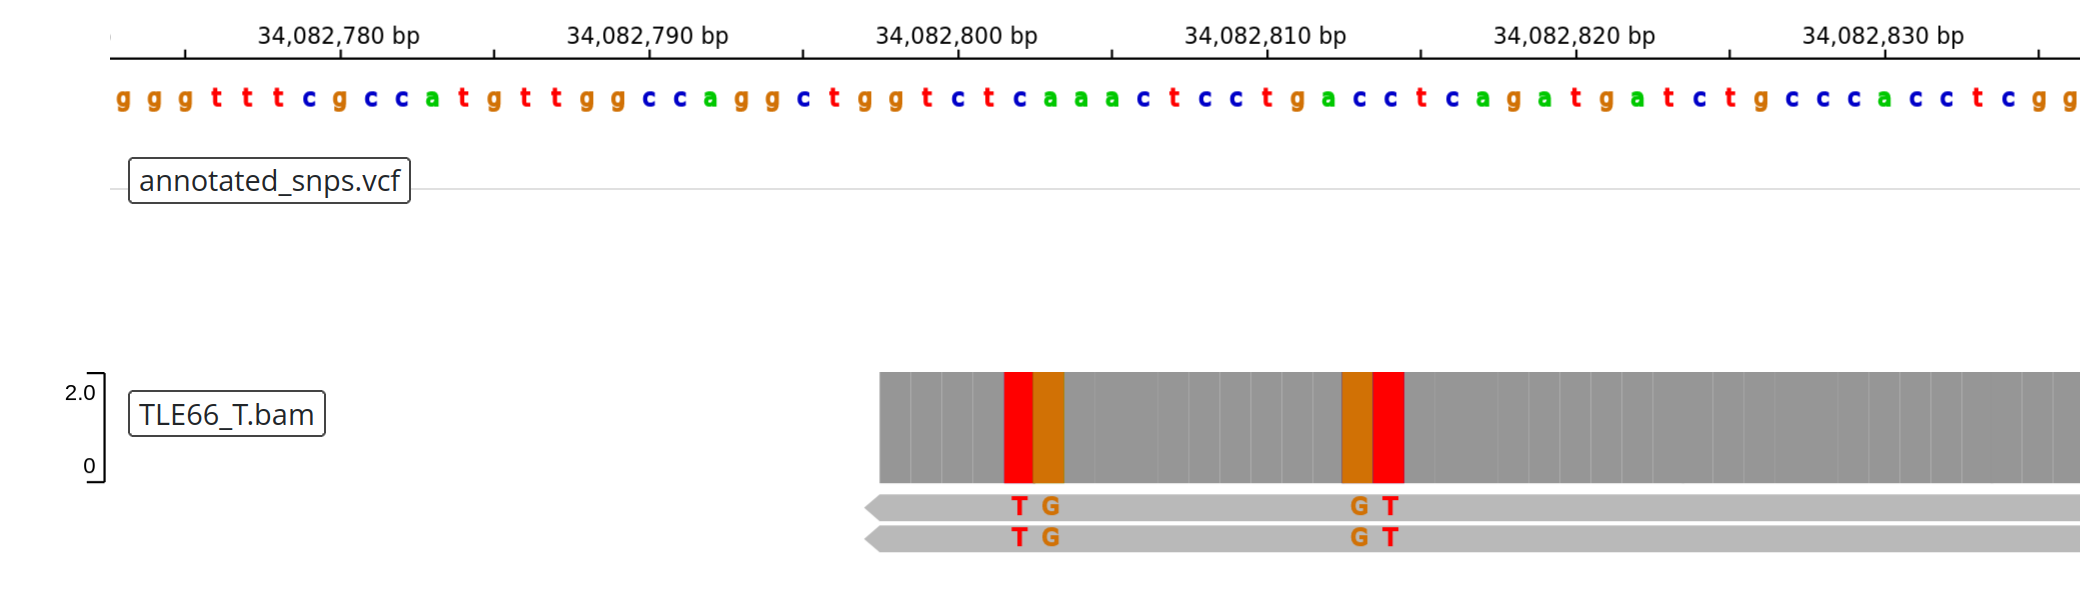

## SNP filtering & cleaning using `vt`

In [21]:
cat raw_snps.vcf \
    | vt decompose - \
    | vt normalize -n -r $DB - \
    | vt uniq - \
    | vt view -f "QUAL>20" -h - \
    > clean_snps.vcf

uniq v0.57

options:     input VCF file        -
         [o] output VCF file       -
decompose v0.5

options:     input VCF file        -
         [s] smart decomposition   false (experimental)
         [o] output VCF file       -

normalize v0.5

options:     input VCF file                                  -
         [o] output VCF file                                 -
         [w] sorting window size                             10000
         [n] no fail on reference inconsistency for non SNPs true
         [q] quiet                                           false
         [d] debug                                           false
         [r] reference FASTA file                            /staging/leuven/stg_00079/teaching/hg19_9/chr9.fa

[variant_manip.cpp:75 is_ref_consistent] Variant is not consistent: chr9:127736257-127736288 - Tcacacacacacacacacacacacacacacac(REF) vs CCTCCCTACCTGGAGACCTTTCCTGTGTATCC(FASTA)
[normalize.cpp:183 normalize] Normalization skipped due to inconsisten

#### Quality control

* Same as above
* You can compare now - you should have less, higher quality variants
* Find a few nice SNPs and check them in IGV (eg, sort on column 6 in the vcf file)

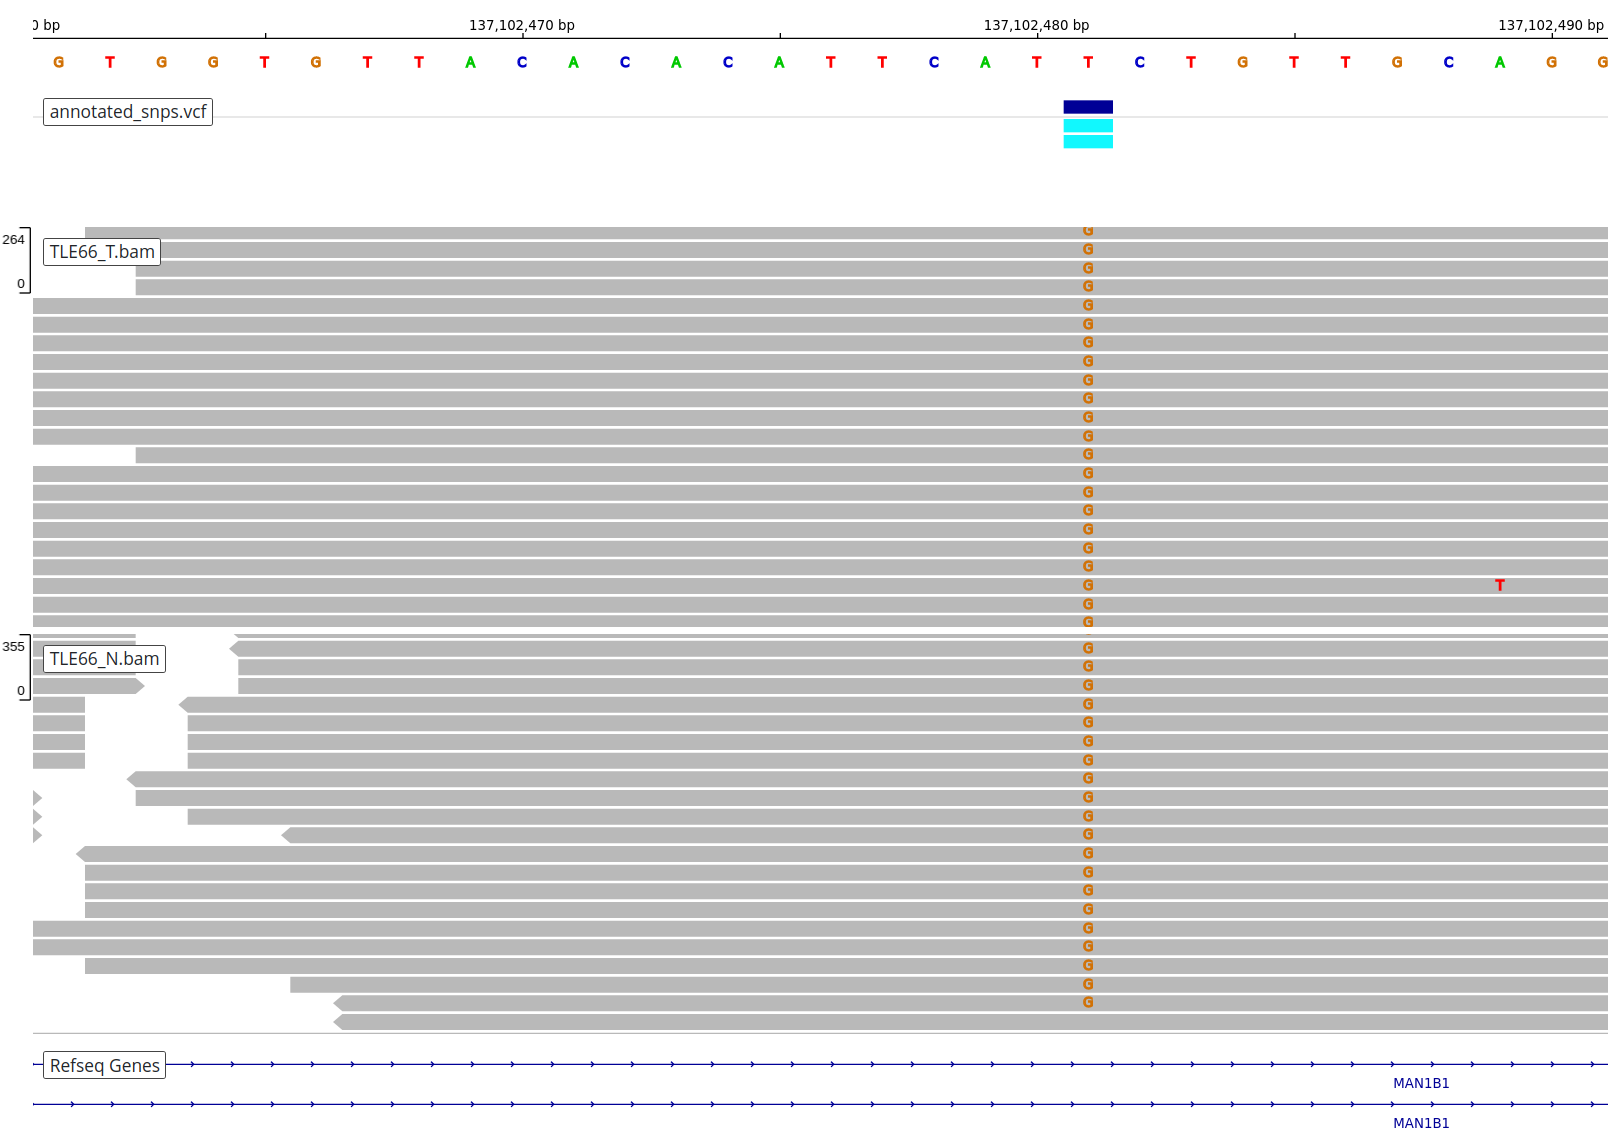


## Snp Annotation using SnpEff

In [22]:
# get help using:
snpEff

SnpEff version SnpEff 5.0e (build 2021-03-09 06:01), by Pablo Cingolani
Usage: snpEff [command] [options] [files]

Run 'java -jar snpEff.jar command' for help on each specific command

Available commands: 
	[eff|ann]                    : Annotate variants / calculate effects (you can use either 'ann' or 'eff', they mean the same). Default: ann (no command or 'ann').
	build                        : Build a SnpEff database.
	buildNextProt                : Build a SnpEff for NextProt (using NextProt's XML files).
	cds                          : Compare CDS sequences calculated form a SnpEff database to the one in a FASTA file. Used for checking databases correctness.
	closest                      : Annotate the closest genomic region.
	count                        : Count how many intervals (from a BAM, BED or VCF file) overlap with each genomic interval.
	databases                    : Show currently available databases (from local config file).
	download                     : Download a

: 255

In [23]:
# sorry this is ugly - but to run snpEff - we need more memory
# I'm sure there is a more elegant way - but I could not find it..

SNPEFF_JAR="${VSC_DATA}/miniconda3/pkgs/snpeff-5.0-hdfd78af_1/share/snpeff-5.0-1/snpEff.jar"
java -Xmx4096m -jar ${SNPEFF_JAR} eff GRCh38.99 -dataDir /staging/leuven/stg_00079/teaching/snpeff_db \
        clean_snps.vcf > annotated_snps.vcf

#### Quality control

* Same as above
* But you should have annoatated
* Try to find some variants that are different between the two samples, and have an interesting SNPeff annotation